<a href="https://colab.research.google.com/github/gkiflex/MSAI-630-A01/blob/master/fashion_mnist_auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# STEP 1: Install and Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available:  []


In [3]:
# STEP 2: Set Parameters
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 10  # Increased for better training

print("Parameters set:")
print(f"Image Size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"Embedding Dimension: {EMBEDDING_DIM}")
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")


Parameters set:
Image Size: 32x32
Embedding Dimension: 2
Epochs: 10
Batch Size: 100


In [4]:
# STEP 3: Load and Preprocess the Fashion-MNIST Dataset
def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

# Load the data
print("Loading Fashion-MNIST dataset...")
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

print(f"Original training data shape: {x_train.shape}")
print(f"Original test data shape: {x_test.shape}")

# Preprocess the data
x_train = preprocess(x_train)
x_test = preprocess(x_test)

print(f"Preprocessed training data shape: {x_train.shape}")
print(f"Preprocessed test data shape: {x_test.shape}")

# Fashion-MNIST class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Loading Fashion-MNIST dataset...
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Original training data shape: (60000, 28, 28)
Original test data shape: (10000, 28, 28)
Preprocessed training data shape: (60000, 32, 32, 1)
Preprocessed test data shape: (10000, 32, 32, 1)


Displaying sample training images:


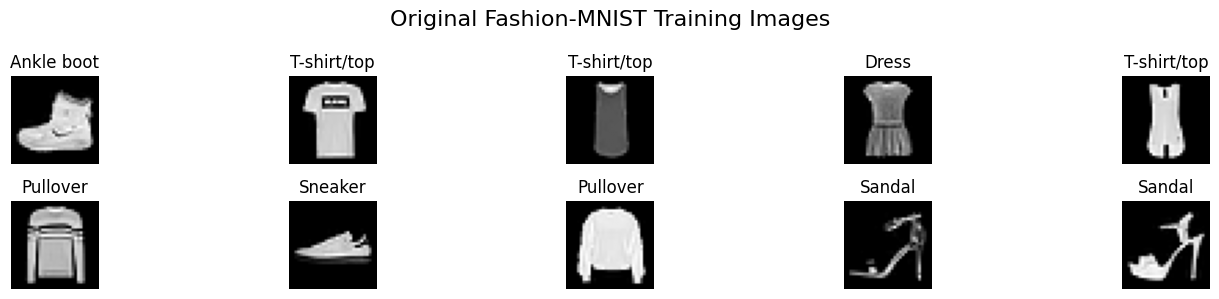

In [5]:
# STEP 4: Display Sample Images
def display_images(images, labels=None, n_images=10, title="Sample Images"):
    """Display a grid of images"""
    plt.figure(figsize=(15, 3))
    plt.suptitle(title, fontsize=16)

    for i in range(n_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.axis('off')
        if labels is not None:
            plt.title(f"{class_names[labels[i]]}")
    plt.tight_layout()
    plt.show()

print("Displaying sample training images:")
display_images(x_train, y_train, title="Original Fashion-MNIST Training Images")

In [6]:
# STEP 5: Build the Encoder
print("Building the Encoder...")

encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)

# Encoder architecture
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)

# Store shape before flattening for the decoder
shape_before_flattening = K.int_shape(x)[1:]
print(f"Shape before flattening: {shape_before_flattening}")

x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

Building the Encoder...
Shape before flattening: (4, 4, 128)


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# STEP 6: Build the Decoder
print("\nBuilding the Decoder...")

decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")

# Decoder architecture
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)

x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)

decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()


Building the Decoder...


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# STEP 7: Build the Complete Autoencoder
print("\nBuilding the Complete Autoencoder...")

autoencoder = models.Model(
    encoder_input,
    decoder(encoder_output),
    name="autoencoder"
)
autoencoder.summary()


Building the Complete Autoencoder...


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 32, 32, 1)      │       246,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,043 (1.31 MB)

 Trainable params: 343,043 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# STEP 8: Compile and Train the Autoencoder
print("\nCompiling the autoencoder...")
autoencoder.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['mse']
)

# Create callbacks for better training monitoring
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7
)

print("Starting training...")
history = autoencoder.fit(
    x_train,
    x_train,  # Autoencoder tries to reconstruct the input
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("Training completed!")


Compiling the autoencoder...
Starting training...
Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 227s 373ms/step - loss: 0.3576 - mse: 0.0591 - val_loss: 0.2601 - val_mse: 0.0251 - learning_rate: 0.0010
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 263s 374ms/step - loss: 0.2580 - mse: 0.0249 - val_loss: 0.2564 - val_mse: 0.0240 - learning_rate: 0.0010
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 261s 372ms/step - loss: 0.2548 - mse: 0.0239 - val_loss: 0.2536 - val_mse: 0.0231 - learning_rate: 0.0010
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 224s 374ms/step - loss: 0.2523 - mse: 0.0231 - val_loss: 0.2526 - val_mse: 0.0228 - learning_rate: 0.0010
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 261s 373ms/step - loss: 0.2507 - mse: 0.0226 - val_loss: 0.2510 - val_mse: 0.0223 - learning_rate: 0.0010
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 254s 360ms/step - loss: 0.2497 - mse: 0.0223 - val_loss: 0.2505 - val_mse: 0.0221 - learning_rate: 0.0010
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 274s 379ms/step - loss: 0.2481 - 

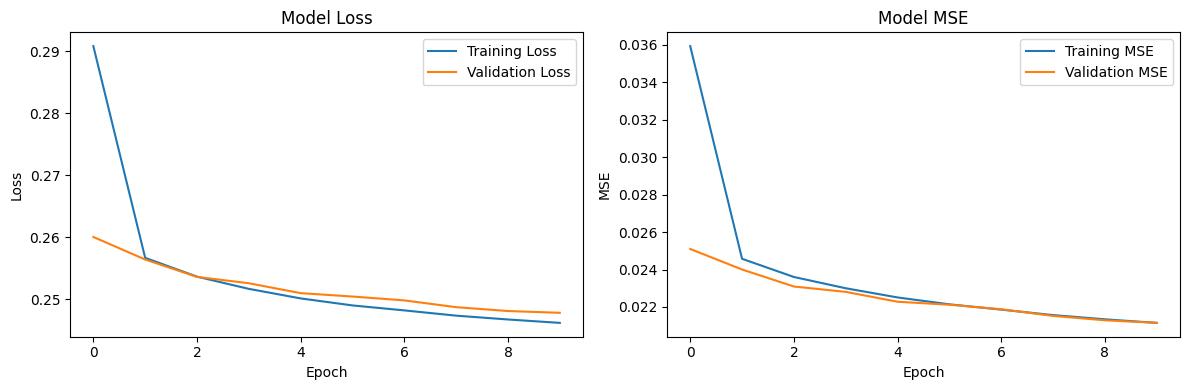

In [10]:
# STEP 9: Plot Training History
def plot_training_history(history):
    """Plot training and validation loss"""
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mse'], label='Training MSE')
    plt.plot(history.history['val_mse'], label='Validation MSE')
    plt.title('Model MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [11]:
# STEP 10: Test Reconstruction - Choose 5 Specific Images
print("\nTesting reconstruction on 5 selected images...")

# Select 5 specific images (one from each class type for variety)
selected_indices = [0, 1000, 2000, 3000, 4000]  # You can change these indices
selected_images = x_test[selected_indices]
selected_labels = y_test[selected_indices]

print("Selected image classes:")
for i, idx in enumerate(selected_indices):
    print(f"Image {i+1}: {class_names[selected_labels[i]]}")

# Get reconstructions
reconstructed_images = autoencoder.predict(selected_images)



Testing reconstruction on 5 selected images...
Selected image classes:
Image 1: Ankle boot
Image 2: T-shirt/top
Image 3: Bag
Image 4: Trouser
Image 5: T-shirt/top
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


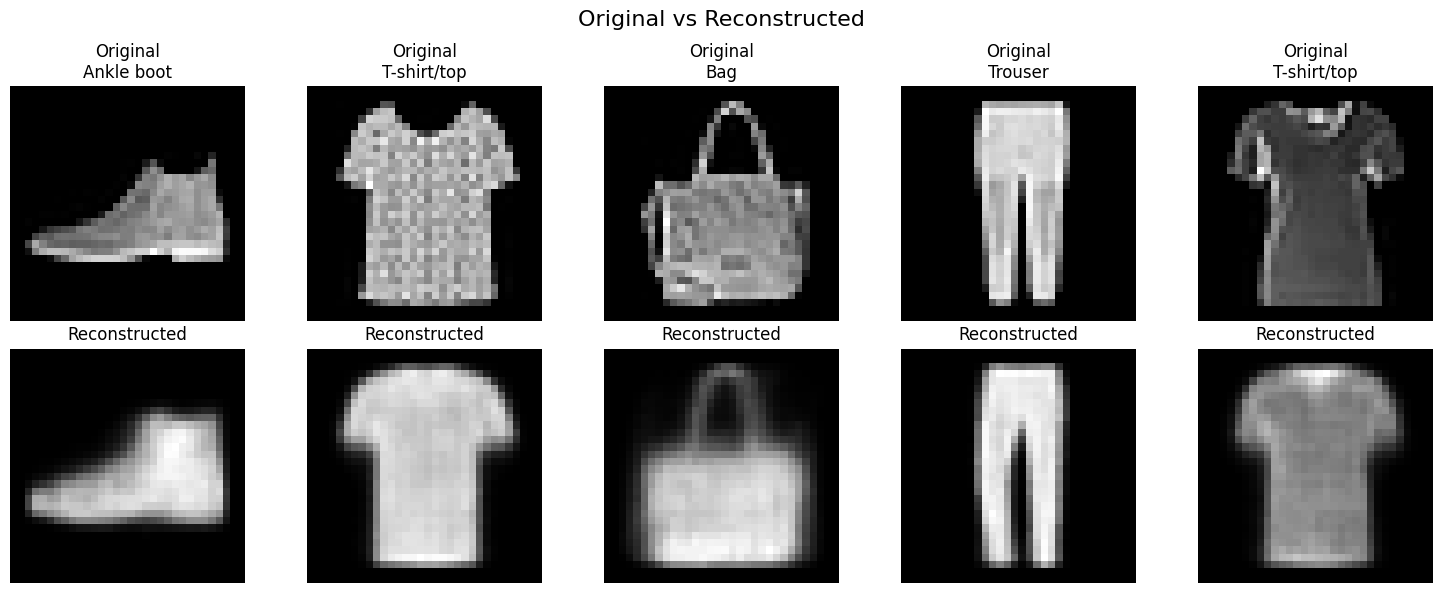

In [12]:
# STEP 11: Display Original vs Reconstructed Images
def compare_images(original, reconstructed, labels, title="Original vs Reconstructed"):
    """Compare original and reconstructed images side by side"""
    n_images = len(original)
    plt.figure(figsize=(15, 6))
    plt.suptitle(title, fontsize=16)

    for i in range(n_images):
        # Original image
        plt.subplot(2, n_images, i + 1)
        plt.imshow(original[i].squeeze(), cmap='gray')
        plt.title(f"Original\n{class_names[labels[i]]}")
        plt.axis('off')

        # Reconstructed image
        plt.subplot(2, n_images, n_images + i + 1)
        plt.imshow(reconstructed[i].squeeze(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

compare_images(selected_images, reconstructed_images, selected_labels)

In [13]:
# STEP 12: Quantitative Analysis of Reconstruction Quality
def analyze_reconstruction_quality(original, reconstructed, labels):
    """Analyze the quality of reconstructions"""
    print("=== RECONSTRUCTION QUALITY ANALYSIS ===\n")

    for i in range(len(original)):
        mse = np.mean((original[i] - reconstructed[i]) ** 2)
        ssim_score = tf.image.ssim(
            tf.expand_dims(original[i], 0),
            tf.expand_dims(reconstructed[i], 0),
            max_val=1.0
        ).numpy()[0]

        print(f"Image {i+1} ({class_names[labels[i]]}):")
        print(f"  - MSE: {mse:.6f}")
        print(f"  - SSIM: {ssim_score:.4f}")
        print(f"  - Reconstruction Quality: {'Good' if ssim_score > 0.7 else 'Fair' if ssim_score > 0.5 else 'Poor'}")
        print()

analyze_reconstruction_quality(selected_images, reconstructed_images, selected_labels)

=== RECONSTRUCTION QUALITY ANALYSIS ===

Image 1 (Ankle boot):
  - MSE: 0.013820
  - SSIM: 0.5208
  - Reconstruction Quality: Fair

Image 2 (T-shirt/top):
  - MSE: 0.035149
  - SSIM: 0.2815
  - Reconstruction Quality: Poor

Image 3 (Bag):
  - MSE: 0.019269
  - SSIM: 0.3434
  - Reconstruction Quality: Poor

Image 4 (Trouser):
  - MSE: 0.017165
  - SSIM: 0.7427
  - Reconstruction Quality: Good

Image 5 (T-shirt/top):
  - MSE: 0.009624
  - SSIM: 0.5264
  - Reconstruction Quality: Fair



In [14]:
# STEP 13: Detailed Discrepancy Analysis
def analyze_discrepancies(original, reconstructed, labels):
    """Provide detailed analysis of discrepancies"""
    print("=== DETAILED DISCREPANCY ANALYSIS ===\n")

    for i in range(len(original)):
        orig_img = original[i].squeeze()
        recon_img = reconstructed[i].squeeze()
        diff_img = np.abs(orig_img - recon_img)

        print(f"Image {i+1} - {class_names[labels[i]]}:")

        # Statistical analysis
        print(f"  Original image stats:")
        print(f"    - Mean intensity: {np.mean(orig_img):.3f}")
        print(f"    - Std deviation: {np.std(orig_img):.3f}")
        print(f"    - Min/Max: {np.min(orig_img):.3f}/{np.max(orig_img):.3f}")

        print(f"  Reconstructed image stats:")
        print(f"    - Mean intensity: {np.mean(recon_img):.3f}")
        print(f"    - Std deviation: {np.std(recon_img):.3f}")
        print(f"    - Min/Max: {np.min(recon_img):.3f}/{np.max(recon_img):.3f}")

        print(f"  Discrepancies:")
        print(f"    - Mean absolute error: {np.mean(diff_img):.4f}")
        print(f"    - Max absolute error: {np.max(diff_img):.4f}")
        print(f"    - Percentage of pixels with >0.1 error: {100 * np.mean(diff_img > 0.1):.1f}%")

        # Visual characteristics
        if 'T-shirt' in class_names[labels[i]] or 'Shirt' in class_names[labels[i]]:
            print(f"    - Common issues: Blurring of fine details, collar/sleeve definition loss")
        elif 'Shoe' in class_names[labels[i]] or 'Sandal' in class_names[labels[i]]:
            print(f"    - Common issues: Loss of texture details, sole pattern simplification")
        elif 'Bag' in class_names[labels[i]]:
            print(f"    - Common issues: Handle details, strap definition loss")
        elif 'Trouser' in class_names[labels[i]]:
            print(f"    - Common issues: Seam details, pocket definition")
        else:
            print(f"    - Common issues: Overall shape preserved, fine texture details lost")
        print()

analyze_discrepancies(selected_images, reconstructed_images, selected_labels)


=== DETAILED DISCREPANCY ANALYSIS ===

Image 1 - Ankle boot:
  Original image stats:
    - Mean intensity: 0.128
    - Std deviation: 0.246
    - Min/Max: 0.000/1.000
  Reconstructed image stats:
    - Mean intensity: 0.130
    - Std deviation: 0.209
    - Min/Max: 0.000/0.640
  Discrepancies:
    - Mean absolute error: 0.0498
    - Max absolute error: 0.6300
    - Percentage of pixels with >0.1 error: 15.1%
    - Common issues: Overall shape preserved, fine texture details lost

Image 2 - T-shirt/top:
  Original image stats:
    - Mean intensity: 0.320
    - Std deviation: 0.341
    - Min/Max: 0.000/1.000
  Reconstructed image stats:
    - Mean intensity: 0.296
    - Std deviation: 0.314
    - Min/Max: 0.000/0.816
  Discrepancies:
    - Mean absolute error: 0.0942
    - Max absolute error: 0.8135
    - Percentage of pixels with >0.1 error: 27.4%
    - Common issues: Blurring of fine details, collar/sleeve definition loss

Image 3 - Bag:
  Original image stats:
    - Mean intensity: 0.

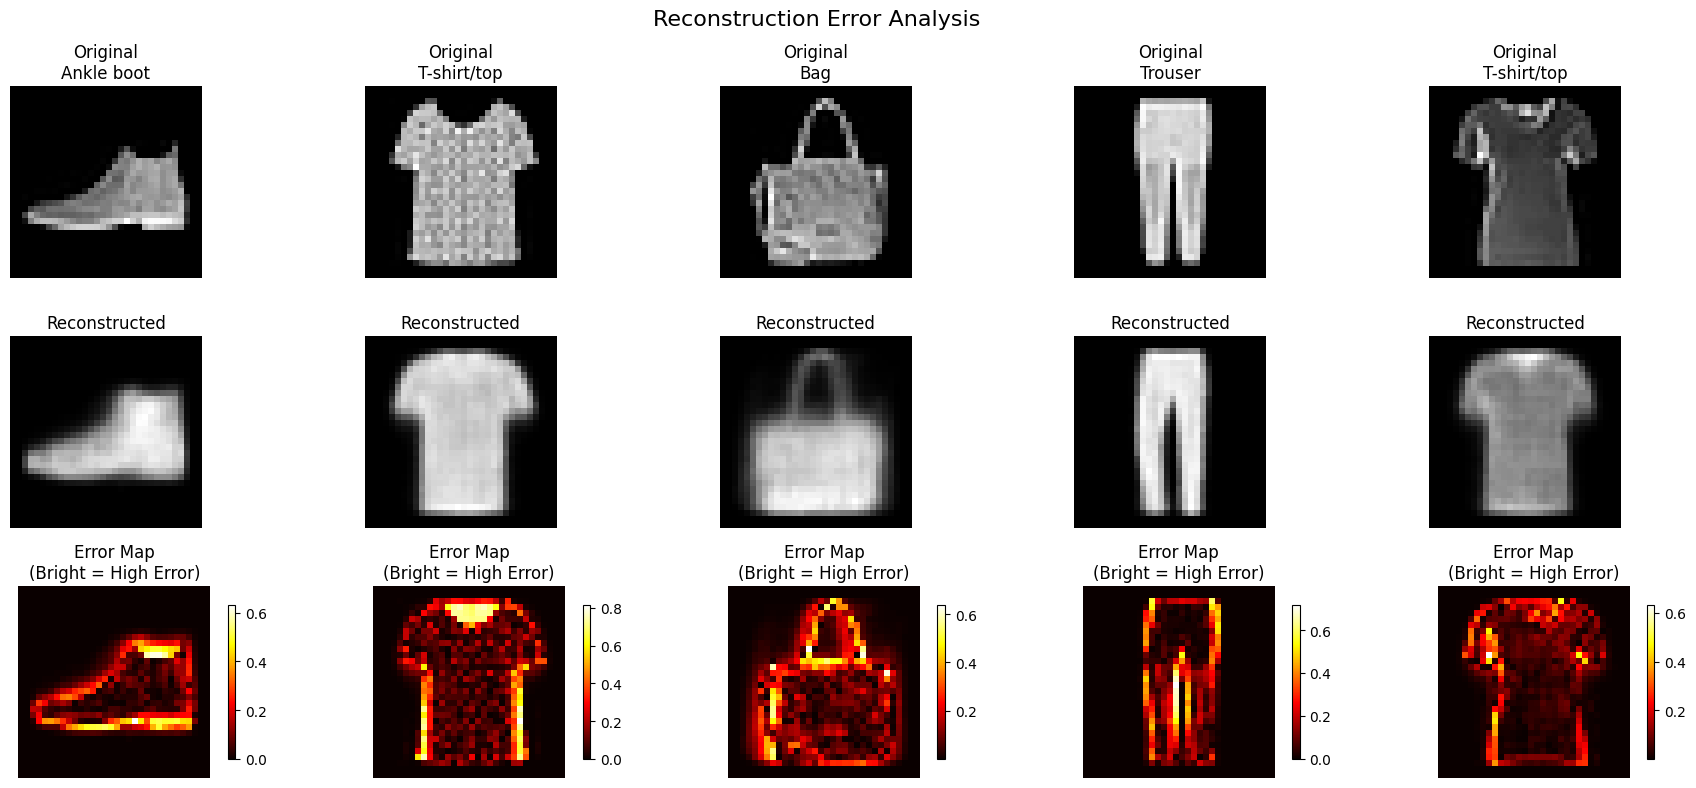

In [15]:
# STEP 14: Visualize Difference Maps
def plot_difference_maps(original, reconstructed, labels):
    """Plot difference maps showing reconstruction errors"""
    n_images = len(original)
    plt.figure(figsize=(18, 8))
    plt.suptitle("Reconstruction Error Analysis", fontsize=16)

    for i in range(n_images):
        # Original
        plt.subplot(3, n_images, i + 1)
        plt.imshow(original[i].squeeze(), cmap='gray')
        plt.title(f"Original\n{class_names[labels[i]]}")
        plt.axis('off')

        # Reconstructed
        plt.subplot(3, n_images, n_images + i + 1)
        plt.imshow(reconstructed[i].squeeze(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

        # Difference map
        plt.subplot(3, n_images, 2 * n_images + i + 1)
        diff = np.abs(original[i].squeeze() - reconstructed[i].squeeze())
        plt.imshow(diff, cmap='hot')
        plt.title(f"Error Map\n(Bright = High Error)")
        plt.axis('off')
        plt.colorbar(shrink=0.8)

    plt.tight_layout()
    plt.show()

plot_difference_maps(selected_images, reconstructed_images, selected_labels)



Exploring the latent space...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


AttributeError: 'str' object has no attribute 'get_text'

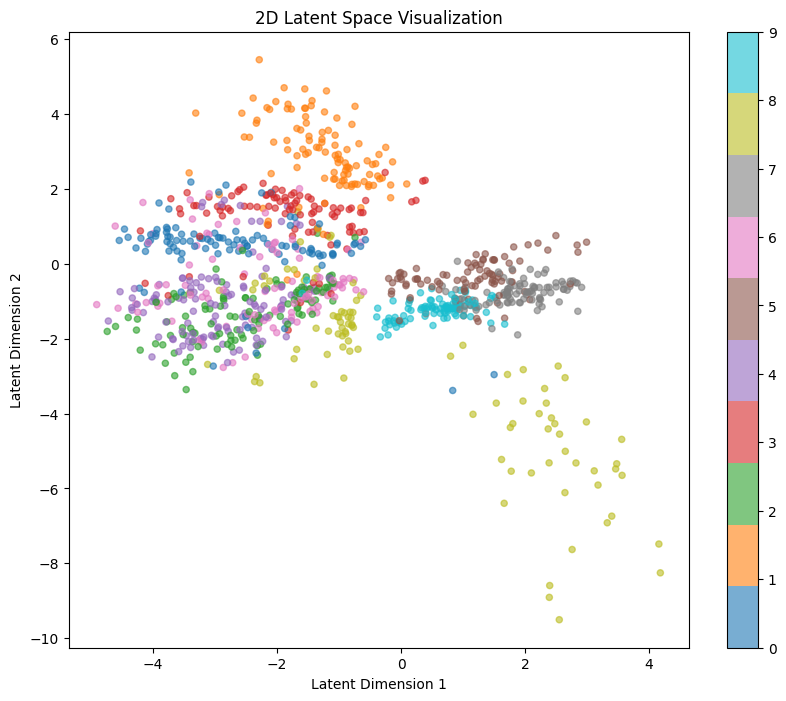

In [16]:
# STEP 15: Explore the Latent Space
print("\nExploring the latent space...")

# Encode a larger sample for visualization
n_sample = 1000
sample_images = x_test[:n_sample]
sample_labels = y_test[:n_sample]
embeddings = encoder.predict(sample_images)

# Visualize the latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1],
                     c=sample_labels, cmap='tab10', alpha=0.6, s=20)
plt.colorbar(scatter)
plt.title('2D Latent Space Visualization')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')

# Add legend
handles, labels = scatter.legend_elements()
legend_labels = [class_names[int(float(label.get_text()))] for label in labels]
plt.legend(handles, legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Generating new images from latent space...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


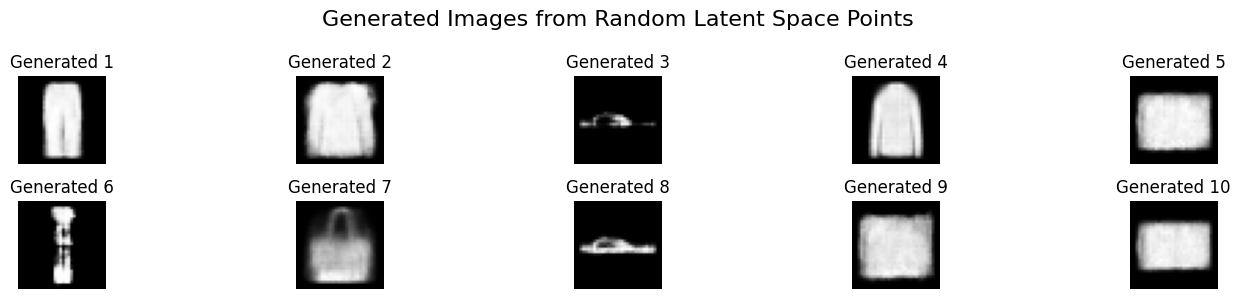

=== ASSIGNMENT COMPLETION SUMMARY ===
* Encoder built successfully
* Decoder built successfully
* Autoencoder trained successfully
* Reconstruction testing completed on 5 selected images
* Detailed discrepancy analysis provided
* Quantitative metrics calculated (MSE, SSIM)
* Visual error maps generated
* Latent space exploration completed

The autoencoder successfully learned to compress Fashion-MNIST images
into a 2D latent space and reconstruct them with reasonable quality.


In [17]:
# STEP 16: Generate New Images from Latent Space
print("Generating new images from latent space...")

# Sample points from the latent space
n_generated = 10
latent_min = np.min(embeddings, axis=0)
latent_max = np.max(embeddings, axis=0)

# Generate random points in the latent space
random_latent_points = np.random.uniform(latent_min, latent_max,
                                        (n_generated, EMBEDDING_DIM))

# Decode these points to generate new images
generated_images = decoder.predict(random_latent_points)

# Display generated images
plt.figure(figsize=(15, 3))
plt.suptitle("Generated Images from Random Latent Space Points", fontsize=16)
for i in range(n_generated):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_images[i].squeeze(), cmap='gray')
    plt.title(f"Generated {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

print("=== ASSIGNMENT COMPLETION SUMMARY ===")
print("* Encoder built successfully")
print("* Decoder built successfully")
print("* Autoencoder trained successfully")
print("* Reconstruction testing completed on 5 selected images")
print("* Detailed discrepancy analysis provided")
print("* Quantitative metrics calculated (MSE, SSIM)")
print("* Visual error maps generated")
print("* Latent space exploration completed")
print("\nThe autoencoder successfully learned to compress Fashion-MNIST images")
print("into a 2D latent space and reconstruct them with reasonable quality.")